In [1]:
!pip install torch transformers datasets
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
from transformers import AlbertTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch

# Load dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")
train_data = dataset["train"]
test_data = dataset["test"]

# Initialize tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Map pos_tags and ner_tags to indices
pos_tag_vocab = {tag: idx for idx, tag in enumerate(sorted(set(sum(train_data['pos_tags'], []))))}
ner_tag_vocab = {tag: idx for idx, tag in enumerate(sorted(set(sum(train_data['ner_tags'], []))))}

def encode(examples):
    tokenized_inputs = tokenizer(examples['tokens'], is_split_into_words=True, truncation=True, padding='max_length', max_length=128)
    max_len = 128
    # Convert and pad ner_tags and pos_tags
    tokenized_inputs['ner_tags'] = [[ner_tag_vocab[tag] for tag in tags] + [-100] * (max_len - len(tags)) for tags in examples['ner_tags']]
    tokenized_inputs['pos_tags'] = [[pos_tag_vocab[tag] for tag in tags] + [-100] * (max_len - len(tags)) for tags in examples['pos_tags']]
    return tokenized_inputs


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [3]:
# Apply the function and prepare datasets
train_data = train_data.map(encode, batched=True)
test_data = test_data.map(encode, batched=True)

train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'ner_tags', 'pos_tags'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'ner_tags', 'pos_tags'])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

In [4]:
import torch
from torch import nn
from transformers import AlbertModel

# Model definition
class AlbertRNN(nn.Module):
    def __init__(self, num_pos_tags, num_ner_tags):
        super(AlbertRNN, self).__init__()
        self.albert = AlbertModel.from_pretrained('albert-base-v2')
        self.rnn = nn.GRU(input_size=768, hidden_size=256, num_layers=2, batch_first=True, bidirectional=True)
        self.fc_ner = nn.Linear(512, num_ner_tags)
        self.fc_pos = nn.Linear(512, num_pos_tags)

    def forward(self, input_ids, attention_mask):
        encoded_layers = self.albert(input_ids, attention_mask=attention_mask)[0]
        rnn_output, _ = self.rnn(encoded_layers)
        ner_output = self.fc_ner(rnn_output)
        pos_output = self.fc_pos(rnn_output)
        return ner_output, pos_output

## using CrossEntropyLoss for loss function

In [13]:
# Instantiate the model
num_pos_tags = len(pos_tag_vocab)
num_ner_tags = len(ner_tag_vocab)
model = AlbertRNN(num_pos_tags, num_ner_tags)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [14]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True, padding_value=0)

    # Padding ner_tags and pos_tags to the maximum length in the batch
    ner_tags = pad_sequence([torch.tensor(item['ner_tags']) for item in batch], batch_first=True, padding_value=-100)
    pos_tags = pad_sequence([torch.tensor(item['pos_tags']) for item in batch], batch_first=True, padding_value=-100)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'ner_tags': ner_tags, 'pos_tags': pos_tags}

# Update DataLoader with the custom collate function
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [15]:
def train(model, train_loader, optimizer, criterion, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, ner_tags, pos_tags = batch['input_ids'], batch['attention_mask'], batch['ner_tags'], batch['pos_tags']
            optimizer.zero_grad()
            ner_output, pos_output = model(input_ids, attention_mask)

            # Flatten the outputs and labels
            ner_output = ner_output.view(-1, ner_output.shape[-1])  # Shape: (batch_size * sequence_length, num_ner_tags)
            pos_output = pos_output.view(-1, pos_output.shape[-1])  # Shape: (batch_size * sequence_length, num_pos_tags)
            ner_tags = ner_tags.view(-1)  # Shape: (batch_size * sequence_length)
            pos_tags = pos_tags.view(-1)  # Shape: (batch_size * sequence_length)

            # Calculate losses and sum them
            ner_loss = criterion(ner_output, ner_tags)
            pos_loss = criterion(pos_output, pos_tags)
            loss = ner_loss + pos_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

<ipython-input-14-ce85a97315f5>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ner_tags = pad_sequence([torch.tensor(item['ner_tags']) for item in batch], batch_first=True, padding_value=-100)
<ipython-input-14-ce85a97315f5>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_tags = pad_sequence([torch.tensor(item['pos_tags']) for item in batch], batch_first=True, padding_value=-100)


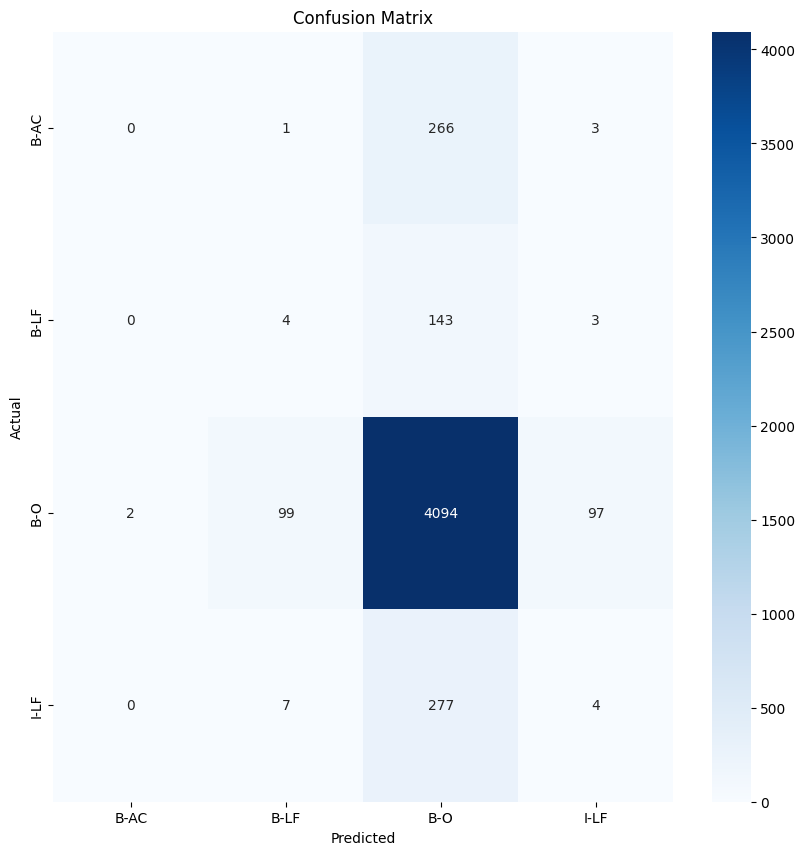

In [16]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, ner_tags, pos_tags = batch['input_ids'], batch['attention_mask'], batch['ner_tags'], batch['pos_tags']
            ner_output, pos_output = model(input_ids, attention_mask)
            ner_preds = torch.argmax(ner_output, dim=-1).view(-1)  # Flatten output
            ner_tags = ner_tags.view(-1)  # Flatten true labels

            # Filter out padding values
            mask = ner_tags != -100
            ner_preds = ner_preds[mask]
            ner_tags = ner_tags[mask]

            all_preds.extend(ner_preds.tolist())
            all_true.extend(ner_tags.tolist())

    return all_true, all_preds

# Collect all predictions and true values
true_labels, predictions = evaluate_model(model, test_loader)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(ner_tag_vocab.keys()), yticklabels=list(ner_tag_vocab.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


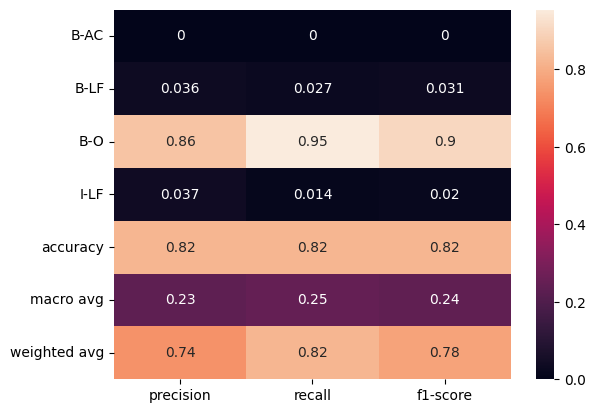

In [17]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming true_labels and predictions have been collected from the model
report = classification_report(true_labels, predictions, target_names=list(ner_tag_vocab.keys()), output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.show()


## loss function using KLDivLoss

In [10]:
# reduction='batchmean' normalizes the loss by the batch size
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

<ipython-input-11-02aa8d5611b0>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ner_tags = pad_sequence([torch.tensor(item['ner_tags']) for item in batch], batch_first=True, padding_value=-100)
<ipython-input-11-02aa8d5611b0>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_tags = pad_sequence([torch.tensor(item['pos_tags']) for item in batch], batch_first=True, padding_value=-100)


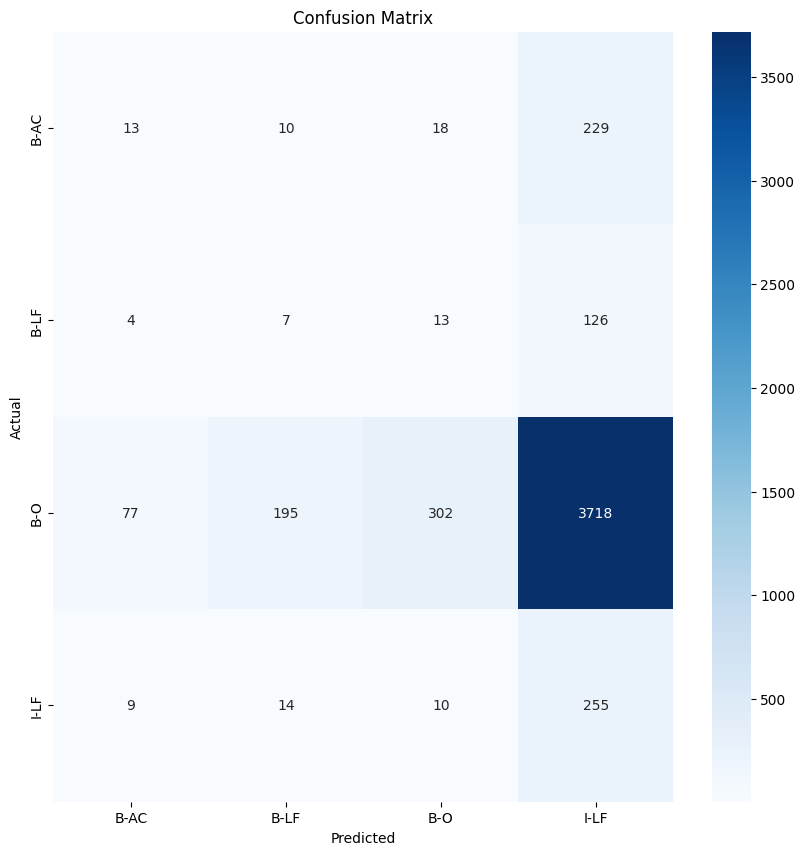

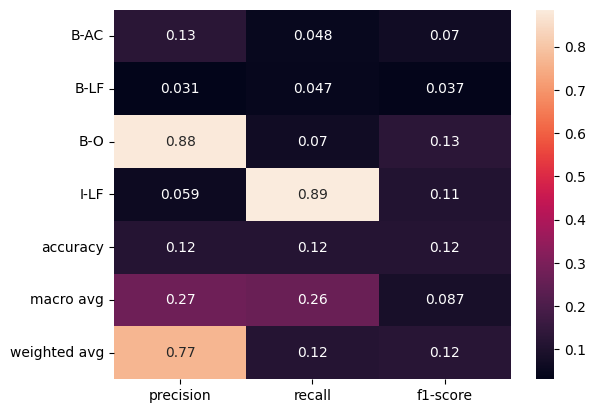

In [11]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True, padding_value=0)

    # Padding ner_tags and pos_tags to the maximum length in the batch
    ner_tags = pad_sequence([torch.tensor(item['ner_tags']) for item in batch], batch_first=True, padding_value=-100)
    pos_tags = pad_sequence([torch.tensor(item['pos_tags']) for item in batch], batch_first=True, padding_value=-100)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'ner_tags': ner_tags, 'pos_tags': pos_tags}

# Update DataLoader with the custom collate function
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=collate_fn)

def train(model, train_loader, optimizer, criterion, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, ner_tags, pos_tags = batch['input_ids'], batch['attention_mask'], batch['ner_tags'], batch['pos_tags']
            optimizer.zero_grad()
            ner_output, pos_output = model(input_ids, attention_mask)

            # Flatten the outputs and labels
            ner_output = ner_output.view(-1, ner_output.shape[-1])  # Shape: (batch_size * sequence_length, num_ner_tags)
            pos_output = pos_output.view(-1, pos_output.shape[-1])  # Shape: (batch_size * sequence_length, num_pos_tags)
            ner_tags = ner_tags.view(-1)  # Shape: (batch_size * sequence_length)
            pos_tags = pos_tags.view(-1)  # Shape: (batch_size * sequence_length)

            # Calculate losses and sum them
            ner_loss = criterion(ner_output, ner_tags)
            pos_loss = criterion(pos_output, pos_tags)
            loss = ner_loss + pos_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, ner_tags, pos_tags = batch['input_ids'], batch['attention_mask'], batch['ner_tags'], batch['pos_tags']
            ner_output, pos_output = model(input_ids, attention_mask)
            ner_preds = torch.argmax(ner_output, dim=-1).view(-1)  # Flatten output
            ner_tags = ner_tags.view(-1)  # Flatten true labels

            # Filter out padding values
            mask = ner_tags != -100
            ner_preds = ner_preds[mask]
            ner_tags = ner_tags[mask]

            all_preds.extend(ner_preds.tolist())
            all_true.extend(ner_tags.tolist())

    return all_true, all_preds

# Collect all predictions and true values
true_labels, predictions = evaluate_model(model, test_loader)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(ner_tag_vocab.keys()), yticklabels=list(ner_tag_vocab.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming true_labels and predictions have been collected from the model
report = classification_report(true_labels, predictions, target_names=list(ner_tag_vocab.keys()), output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.show()


## using CrossEntropyLoss for loss function and AdamW for optimizer

In [24]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

<ipython-input-25-02aa8d5611b0>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ner_tags = pad_sequence([torch.tensor(item['ner_tags']) for item in batch], batch_first=True, padding_value=-100)
<ipython-input-25-02aa8d5611b0>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_tags = pad_sequence([torch.tensor(item['pos_tags']) for item in batch], batch_first=True, padding_value=-100)


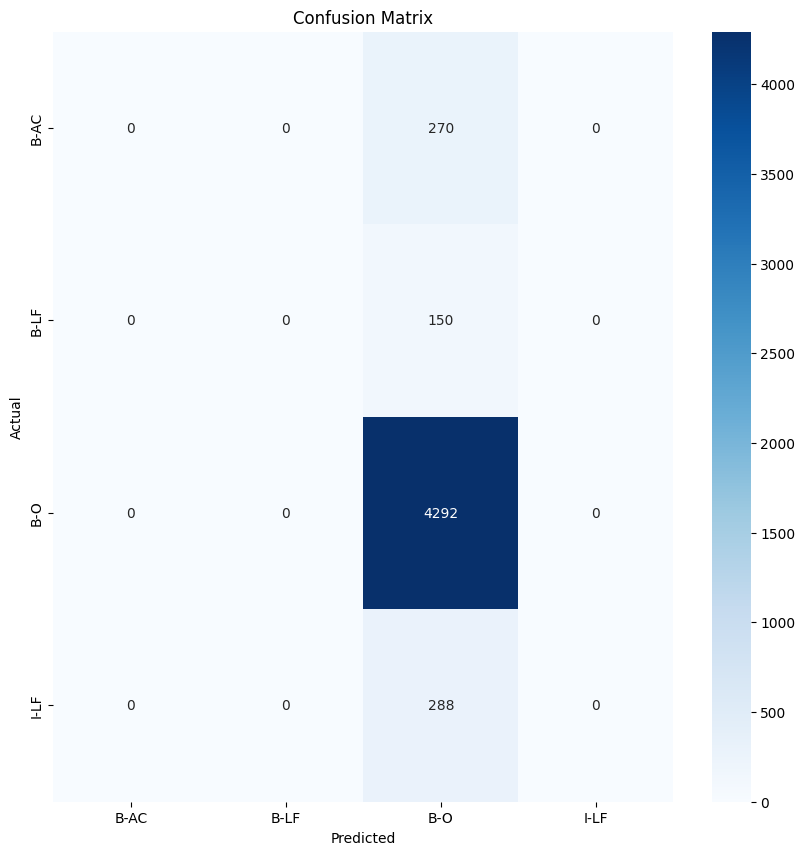

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


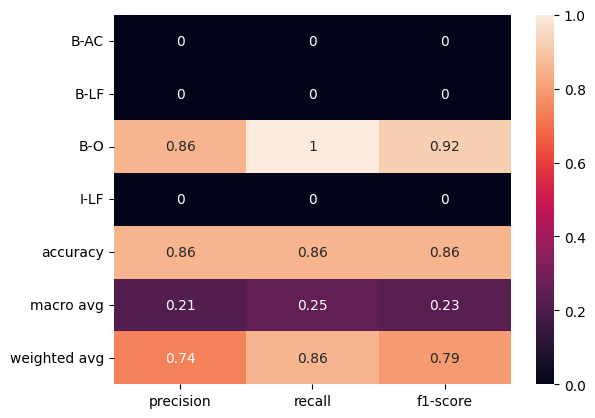

In [25]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids = pad_sequence([item['input_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([item['attention_mask'] for item in batch], batch_first=True, padding_value=0)

    # Padding ner_tags and pos_tags to the maximum length in the batch
    ner_tags = pad_sequence([torch.tensor(item['ner_tags']) for item in batch], batch_first=True, padding_value=-100)
    pos_tags = pad_sequence([torch.tensor(item['pos_tags']) for item in batch], batch_first=True, padding_value=-100)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'ner_tags': ner_tags, 'pos_tags': pos_tags}

# Update DataLoader with the custom collate function
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=collate_fn)

def train(model, train_loader, optimizer, criterion, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, ner_tags, pos_tags = batch['input_ids'], batch['attention_mask'], batch['ner_tags'], batch['pos_tags']
            optimizer.zero_grad()
            ner_output, pos_output = model(input_ids, attention_mask)

            # Flatten the outputs and labels
            ner_output = ner_output.view(-1, ner_output.shape[-1])  # Shape: (batch_size * sequence_length, num_ner_tags)
            pos_output = pos_output.view(-1, pos_output.shape[-1])  # Shape: (batch_size * sequence_length, num_pos_tags)
            ner_tags = ner_tags.view(-1)  # Shape: (batch_size * sequence_length)
            pos_tags = pos_tags.view(-1)  # Shape: (batch_size * sequence_length)

            # Calculate losses and sum them
            ner_loss = criterion(ner_output, ner_tags)
            pos_loss = criterion(pos_output, pos_tags)
            loss = ner_loss + pos_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, ner_tags, pos_tags = batch['input_ids'], batch['attention_mask'], batch['ner_tags'], batch['pos_tags']
            ner_output, pos_output = model(input_ids, attention_mask)
            ner_preds = torch.argmax(ner_output, dim=-1).view(-1)  # Flatten output
            ner_tags = ner_tags.view(-1)  # Flatten true labels

            # Filter out padding values
            mask = ner_tags != -100
            ner_preds = ner_preds[mask]
            ner_tags = ner_tags[mask]

            all_preds.extend(ner_preds.tolist())
            all_true.extend(ner_tags.tolist())

    return all_true, all_preds

# Collect all predictions and true values
true_labels, predictions = evaluate_model(model, test_loader)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(ner_tag_vocab.keys()), yticklabels=list(ner_tag_vocab.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Assuming true_labels and predictions have been collected from the model
report = classification_report(true_labels, predictions, target_names=list(ner_tag_vocab.keys()), output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.show()
